# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries. 필요한 라이브러리 추가로 호출

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                         ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

100%|██████████| 170498071/170498071 [00:04<00:00, 41715221.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  car  ship   cat plane


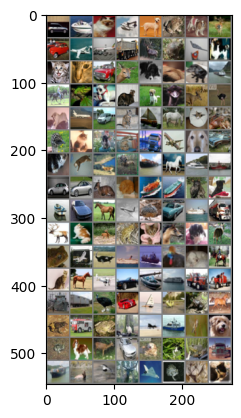

In [ ]:
# Examples of dataset 데이터가 잘 만들어졌음을 확인가능.

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# Model

  class ResidualBlock(nn.Module): #ResidualBlock 클래스를 정의하며, nn.Module(PyTorch의 모든 신경망 모듈의 기본 클래스)을 상속받습니다.
      def __init__(self, in_channels, out_channels, stride=1): #생성자 메서드로, 주어진 입력 채널, 출력 채널, 스트라이드로 ResidualBlock 클래스를 초기화합니다.
          super(ResidualBlock, self).__init__()
          self.stride = stride #스트라이드를 설정합니다.
          self.in_channels = in_channels #입력 채널 수를 설정합니다.
          self.out_channels = out_channels #출력 채널 수를 설정합니다.

          self.conv_block = nn.Sequential( #Sequential 컨테이너를 정의하여 일련의 레이어를 순서대로 실행하도록 합니다.
              nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False), #3x3 커널, 지정된 스트라이드, 패딩=1의 Conv2d 레이어를 추가합니다.
              nn.BatchNorm2d(self.out_channels),#Conv2d 레이어의 출력을 정규화하는 배치 정규화 레이어를 추가합니다.
              nn.ReLU(), #비선형성을 도입하기 위해 ReLU 활성화 함수를 추가합니다.

              nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False), #3x3 커널, 스트라이드=1, 패딩 1의 또 다른 Conv2d 레이어를 추가합니다.
              nn.BatchNorm2d(self.out_channels) #또 다른 배치 정규화 레이어를 추가합니다.
          )

          if self.stride != 1 or self.in_channels != self.out_channels: #스트라이드가 1이 아니거나 입력 채널이 출력 채널과 다르면 실행됩니다.
              self.downsample = nn.Sequential(
                  nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                  #1x1 커널과 지정된 스트라이드를 가진 Conv2d 레이어를 다운샘플링을 위해 추가합니다.
                  nn.BatchNorm2d(self.out_channels) #다운샘플된 출력에 대한 배치 정규화 레이어를 추가합니다.
              )

      def forward(self, x): #ResidualBlock의 순전파를 정의합니다.
          out = self.conv_block(x) #입력을 컨볼루션 블록에 통과시킵니다.
          if self.stride != 1 or self.in_channels != self.out_channels: #다시 다운샘플링이 필요한지 확인합니다.
              x = self.downsample(x) #다운샘플링이 필요한 경우 입력을 다운샘플링 레이어에 통과시킵니다.
          out = F.relu(x + out) #컨볼루션 블록의 출력과 입력을 더한 후 ReLU 활성화를 적용합니다.
          return out #ResidualBlock의 최종 출력을 반환합니다.

  class ResNet(nn.Module):
      def __init__(self, num_blocks, num_classes=10): #각 레이어별 블록 수와 출력 클래스 수를 지정하여 ResNet 클래스를 초기화합니다.
          super(ResNet, self).__init__()
          self.in_channels = 64 #ResNet 레이어의 초기 입력 채널 수를 설정합니다.
          self.base = nn.Sequential( #기본 레이어들을 위한 시퀀셜 컨테이너를 정의합니다.
              nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
              #3x3 커널, 스트라이드=1, 패딩=1의 Conv2d 레이어를 추가하며, 입력 채널 수는 3 (RGB 이미지)입니다.
              nn.BatchNorm2d(64), #Conv2d 레이어의 출력을 정규화하는 배치 정규화 레이어를 추가합니다.
              nn.ReLU() #ReLU 활성화 함수를 추가합니다.
          )

          self.layer1 = self.make_layer(64, num_blocks[0], stride=1) #64 출력 채널과 지정된 블록 수로 첫 번째 레이어를 생성합니다.
          self.layer2 = self.make_layer(128, num_blocks[1], stride=2) #128 출력 채널, 지정된 블록 수, 스트라이드 2로 두 번째 레이어를 생성합니다.
          self.layer3 = self.make_layer(256, num_blocks[2], stride=2) #256 출력 채널, 지정된 블록 수, 스트라이드 2로 세 번째 레이어를 생성합니다.
          self.layer4 = self.make_layer(512, num_blocks[3], stride=2) #512 출력 채널, 지정된 블록 수, 스트라이드 2로 네 번째 레이어를 생성합니다.

          self.gap = nn.AvgPool2d(4) #커널 크기 4의 글로벌 평균 풀링 레이어를 추가합니다.
          self.fc = nn.Linear(512, num_classes) #최종 출력을 위해 지정된 클래스 수로 완전 연결 레이어를 추가합니다.

      def make_layer(self, out_channels, num_block, stride): #레이어의 블록을 생성하는 헬퍼 메서드를 정의합니다.
          strides = [stride] + [1] * (num_block - 1) #첫 번째 블록의 스트라이드를 지정하고 나머지 블록의 스트라이드를 1로 설정하는 리스트를 만듭니다.
          layers = [] #블록을 저장할 빈 리스트를 초기화합니다.

          for stride in strides: #스트라이드 리스트를 반복합니다.
              block = ResidualBlock(self.in_channels, out_channels, stride) #지정된 입력 채널, 출력 채널, 스트라이드로 새로운 ResidualBlock을 생성합니다.
              layers.append(block) #생성된 블록을 레이어 리스트에 추가합니다.
              self.in_channels = out_channels #다음 블록을 위해 입력 채널 수를 출력 채널 수로 업데이트합니다.
          return nn.Sequential(*layers) #생성된 레이어를 Sequential 컨테이너로 반환합니다.


      def forward(self, x): #ResNet 모델의 순전파를 정의합니다.
          out = self.base(x) #입력을 기본 레이어에 통과시킵니다.
          out = self.layer1(out) #출력을 첫 번째 레이어에 통과시킵니다.
          out = self.layer2(out) #출력을 두 번째 레이어에 통과시킵니다.
          out = self.layer3(out) #출력을 세 번째 레이어에 통과시킵니다.
          out = self.layer4(out) #출력을 네 번째 레이어에 통과시킵니다.
          out = self.gap(out) #출력을 글로벌 평균 풀링 레이어에 통과시킵니다.

          out = out.view(out.size(0), -1) #출력 텐서를 (배치 크기, -1)의 형태로 재구성합니다.
          out = self.fc(out) #재구성된 출력을 완전 연결 레이어에 통과시켜 최종 예측을 얻습니다.
          return out
  num_blocks=[3,4,6,3] #ResNet 모델의 네 개 레이어 각각에 포함될 ResidualBlock의 개수를 정의합니다.
  model = ResNet(num_blocks).to(device) #지정된 블록 수로 ResNet 모델 인스턴스를 생성하고, 모델을 지정된 장치(예: GPU 또는 CPU)로 이동시킵니다.


# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
#학습률 스케줄러는 학습 과정에서 학습률을 동적으로 조정하여 더 나은 학습 성능을 얻도록 도와줍니다.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#학습률 스케줄러를 정의합니다. 이 스케줄러는 일정한 에폭(step_size=10)마다 학습률을 gamma 배수만큼 감소시킵니다. 여기서는 매 10 에폭마다 학습률을 0.1배로 줄입니다.
criterion = nn.CrossEntropyLoss()

GroundTruth:    cat  ship  ship plane
Predicted:    car   car truck   car


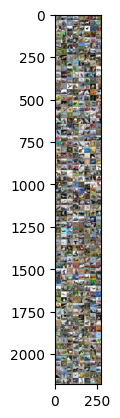

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# **Train the network**

Train your own network using the above loss function and optimizer.

Epoch 1/100 Train loss: 1.550 Train Acc: 43.63% Test loss: 1.413 Test Acc: 47.99%
Epoch 2/100 Train loss: 1.011 Train Acc: 63.66% Test loss: 1.032 Test Acc: 67.50%
Epoch 3/100 Train loss: 0.725 Train Acc: 74.48% Test loss: 0.883 Test Acc: 70.63%
Epoch 4/100 Train loss: 0.564 Train Acc: 80.31% Test loss: 0.700 Test Acc: 76.42%
Epoch 5/100 Train loss: 0.446 Train Acc: 84.45% Test loss: 0.543 Test Acc: 81.59%
Epoch 6/100 Train loss: 0.361 Train Acc: 87.39% Test loss: 0.556 Test Acc: 82.12%
Epoch 7/100 Train loss: 0.283 Train Acc: 90.06% Test loss: 0.525 Test Acc: 82.76%
Epoch 8/100 Train loss: 0.221 Train Acc: 92.12% Test loss: 0.526 Test Acc: 83.62%
Epoch 9/100 Train loss: 0.165 Train Acc: 94.09% Test loss: 0.627 Test Acc: 81.67%
Epoch 10/100 Train loss: 0.135 Train Acc: 95.22% Test loss: 0.589 Test Acc: 84.14%
Epoch 11/100 Train loss: 0.038 Train Acc: 98.96% Test loss: 0.467 Test Acc: 87.53%
Epoch 12/100 Train loss: 0.015 Train Acc: 99.75% Test loss: 0.496 Test Acc: 87.63%
Epoch 13/100 

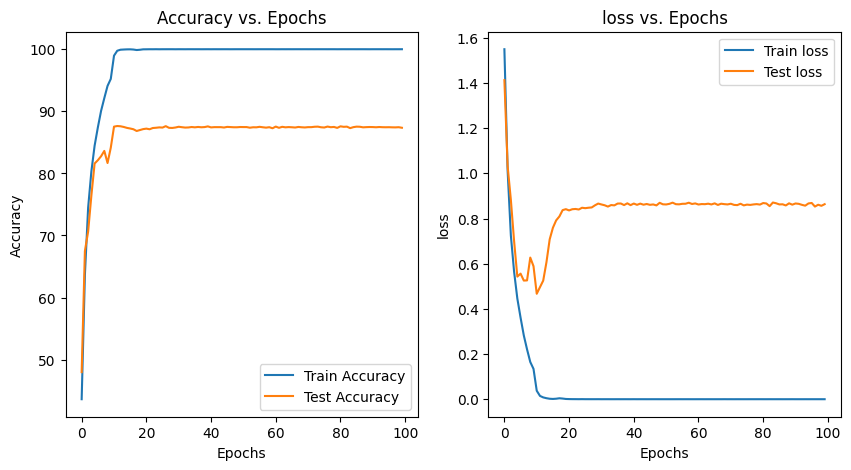

In [ ]:

#필요한 라이브러리 임포트 및 설정:
import matplotlib.pyplot as plt #그래프를 그리기 위한 라이브러리를 호출합니다.
import random
# Assuming you have already defined trainloader and testloader
random.seed(42) #무작위성을 재현 가능하게 하기 위해 랜덤 시드를 설정합니다.

#학습 설정:
epochs = 100  # number of epochs
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []
#각 에포크별 손실 및 정확도를 저장할 리스트입니다.

#모델 학습 및 평가:
for epoch in range(epochs):#각 에포크에 대해 학습 및 평가를 수행합니다.
    # Training phase
    model.train()  #모델을 학습 모드로 설정
    #학습 단계에서 모델을 train() 모드로 설정하고, 입력과 레이블을 장치로 이동시킨 후 순전파, 손실 계산, 역전파, 최적화 단계를 거칩니다.
    total_train = 0
    correct_train = 0
    loss_tmp = 0.0
    epoch_loss_train = 0.0
    for i, data in enumerate(trainloader, start=0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #학습 손실을 누적하고, 정확도를 계산합니다.:
        # Accumulate loss
        epoch_loss_train += loss.data
        loss_tmp += loss.data

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if i % 5000 == 4999:
            loss_tmp = 0.0

    train_loss.append(epoch_loss_train / len(trainloader))
    train_accuracy.append(100 * correct_train / total_train)

    # Testing phase
    model.eval()  # 모델을 평가 모드로 설정
    #평가 단계에서 모델을 eval() 모드로 설정하고, 평가 데이터를 사용하여 손실과 정확도를 계산합니다.
    total_test = 0
    correct_test = 0
    epoch_loss_test = 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            # Accumulate loss
            loss = criterion(outputs, labels)
            epoch_loss_test += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss.append(epoch_loss_test / len(testloader))
    test_accuracy.append(100 * correct_test / total_test)

    # Update learning rate 학습률 스케줄러를 업데이트합니다.
    scheduler.step()

    # Print stats 각 에포크마다 학습 손실, 학습 정확도, 테스트 손실, 테스트 정확도를 출력합니다.
    print(f'Epoch {epoch+1}/{epochs} Train loss: {train_loss[-1]:.3f} Train Acc: {train_accuracy[-1]:.2f}% Test loss: {test_loss[-1]:.3f} Test Acc: {test_accuracy[-1]:.2f}%')

#손실 값 변환: train_loss는 GPU Tensor의 리스트라 가정해 train_loss 리스트의 GPU 텐서를 CPU로 이동시키고, 이를 NumPy 배열로 변환합니다.
train_loss_cpu = [loss.cpu() for loss in train_loss]  # 각 요소를 CPU로 이동
train_loss_numpy = [loss.numpy() for loss in train_loss_cpu]  # 각 요소를 NumPy 배열로 변환

#그래프 그리기: 두 개의 서브플롯을 생성합니다.
plt.figure(figsize=(10, 5))

#첫 번째 서브플롯에는 학습 및 테스트 정확도를 에포크에 따라 그립니다.
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_accuracy, label='Train Accuracy')
plt.plot(range(epochs), test_accuracy, label='Test Accuracy')
plt.title('Accuracy vs. Epochs') #각 그래프에는 제목, 축 라벨, 범례를 추가합니다.
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#두 번째 서브플롯에는 학습 및 테스트 손실을 에포크에 따라 그립니다.
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_loss_numpy, label='Train loss')
plt.plot(range(epochs), test_loss, label='Test loss')
plt.title('loss vs. Epochs') #각 그래프에는 제목, 축 라벨, 범례를 추가합니다.
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show() #plt.show()를 사용하여 그래프를 표시합니다.


## **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


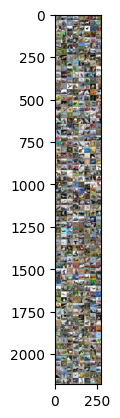

In [ ]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [ ]:
# Test the trained model with overall test dataset

model.eval()
correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = model(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)

    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 12 %

Accuracy of the network on the 10,000 test images: 87 %
